In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## VSB sgan

Modified from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/sgan/sgan.py

In [3]:
import argparse
import os
import numpy as np
import math
from pathlib import Path

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [4]:
torch.cuda.set_device(1)

In [5]:
cuda = True

In [6]:
#os.makedirs('images', exist_ok=True)

In [11]:
path = Path('../input/train_300_bp_500Hz-40MHz_aug/')

In [17]:
n_epochs=200
batch_size=16
#adam: learning rate
lr=0.0002
#adam: decay of first order momentum of gradient
b1=0.5
#adam: decay of first order momentum of gradient
b2=0.999
#number of cpu threads to use during batch generation
n_cpu=8
#dimensionality of the latent space
latent_dim=100
#number of classes for dataset
num_classes=2
#size of each image dimension
img_size=300
#number of image channels
channels=3
#interval between image sampling
sample_interval=400

In [18]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img      

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2**4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1),
                                       nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size**2, num_classes + 1),
                                       nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label

In [34]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

In [35]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

In [36]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [37]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout2d(p=0.25)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Dropout2d(p=0.25)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace)
    (13): Dropout2d(p=0.25)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True

In [39]:
# Configure data loader
os.makedirs('../../data/ML_DATA/mnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data/ML_DATA/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(img_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

0.00B [00:00, ?B/s]

9.92MB [00:05, 1.70MB/s]                            


Extracting ../../data/ML_DATA/mnist/MNIST/raw/train-images-idx3-ubyte.gz


0.00B [00:00, ?B/s]

32.8kB [00:00, 34.1kB/s]                            
0.00B [00:00, ?B/s]

Extracting ../../data/ML_DATA/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1.65MB [00:02, 619kB/s]                             
0.00B [00:00, ?B/s]

Extracting ../../data/ML_DATA/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8.19kB [00:00, 13.0kB/s]                   

Extracting ../../data/ML_DATA/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [41]:
# Optimizers
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2))

In [42]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

### Train

In [ ]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(
            1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0),
                        requires_grad=False)
        fake_aux_gt = Variable(LongTensor(batch_size).fill_(
            num_classes), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(
            0, 1, (batch_size, latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        validity, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) +
                       auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) +
                       auxiliary_loss(fake_aux, fake_aux_gt)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate(
            [real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate(
            [labels.data.cpu().numpy(), fake_aux_gt.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()
        if (i==len(dataloader)-1) and epoch % 10 == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader),
                                                                                        d_loss.item(), 100 * d_acc,
                                                                                        g_loss.item()))

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], 'images/%d.png' %
                       batches_done, nrow=5, normalize=True)


[Epoch 0/200] [Batch 937/938] [D loss: 1.292209, acc: 50%] [G loss: 1.234106]
[Epoch 10/200] [Batch 937/938] [D loss: 1.269366, acc: 56%] [G loss: 1.457137]
[Epoch 20/200] [Batch 937/938] [D loss: 1.136564, acc: 64%] [G loss: 1.803623]
[Epoch 30/200] [Batch 937/938] [D loss: 1.049765, acc: 84%] [G loss: 1.199747]
[Epoch 40/200] [Batch 937/938] [D loss: 1.064237, acc: 75%] [G loss: 1.504575]
[Epoch 50/200] [Batch 937/938] [D loss: 0.844713, acc: 93%] [G loss: 0.629558]
[Epoch 60/200] [Batch 937/938] [D loss: 1.203705, acc: 67%] [G loss: 1.044523]
[Epoch 70/200] [Batch 937/938] [D loss: 1.259580, acc: 59%] [G loss: 3.083036]
[Epoch 80/200] [Batch 937/938] [D loss: 0.859626, acc: 95%] [G loss: 4.363213]
[Epoch 90/200] [Batch 937/938] [D loss: 0.823298, acc: 92%] [G loss: 0.782139]
[Epoch 100/200] [Batch 937/938] [D loss: 1.294765, acc: 54%] [G loss: 0.234851]
[Epoch 110/200] [Batch 937/938] [D loss: 1.598531, acc: 34%] [G loss: 2.638474]


## Fastai

### Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [ ]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic(in_size=64, n_channels=3, n_extra_layers=1)

In [ ]:
opt_func = partial(optim.Adam, betas = (0.,0.99))
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func, wd=0.)

epoch,train_loss,gen_loss,disc_loss
1,-0.842719,0.542895,-1.086206
2,-0.799776,0.539448,-1.067940
3,-0.738768,0.538581,-1.015152
4,-0.718174,0.484403,-0.943485
5,-0.570070,0.428915,-0.777247
6,-0.545130,0.413026,-0.749381
7,-0.541453,0.389443,-0.719322
8,-0.469548,0.356602,-0.642670
9,-0.434924,0.329100,-0.598782
10,-0.416448,0.301526,-0.558442


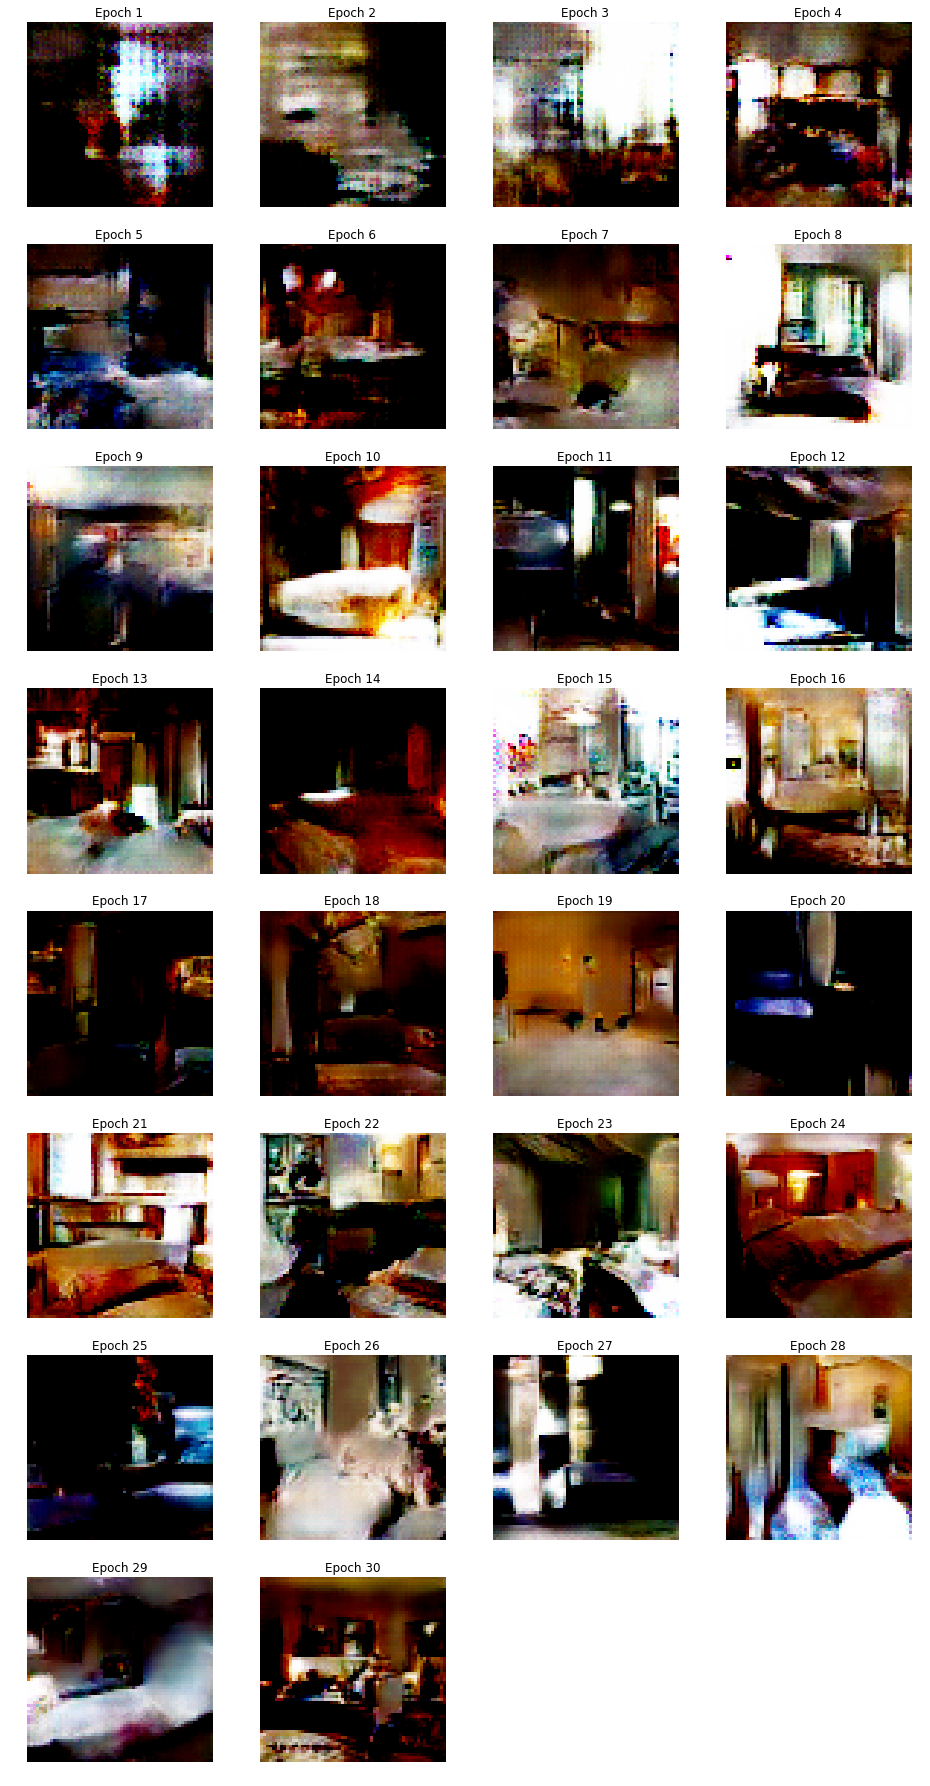

In [ ]:
learn.fit(30,2e-4)

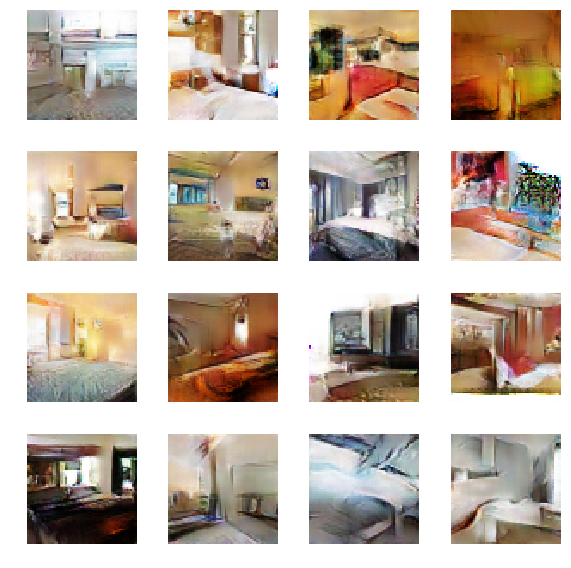

In [ ]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))